In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm.notebook import tqdm
import openpyxl

In [170]:
plt.style.use('ggplot')
df = pd.read_excel('../../stimuli/Stimuli_list.xlsx', engine='openpyxl', sheet_name=0, header=None, usecols=[0, 1, 2, 5], names=['Id', 'News', 'Truthfulness', 'Theme'])
print(df)

     Id                                               News Truthfulness Theme
0     1  La Chine, l'Inde et les Etats Unis, les plus g...       FAUSSE  Just
1     2  Une plainte a pu être déposée contre plusieurs...        VRAIE  Ecol
2     7  La France soutient encore les énergies fossile...        VRAIE  Ecol
3    12  Malgré le Dieselgate, le système de contrôle d...       FAUSSE  Ecol
4    19  En France, seuls 10% des déchets plastiques so...       FAUSSE  Ecol
..  ...                                                ...          ...   ...
91  192  Les émissions françaises de gaz à effet de ser...       FAUSSE  Ecol
92  194  La nouvelle application mobile de prise de not...        VRAIE  Demo
93  205  Le gouvernement promet, via l'application ALIC...        VRAIE  Demo
94  206  La reconnaissance faciale sera bientôt obligat...       FAUSSE  Demo
95  209  Nous pourrions devenir le premier pays europée...        VRAIE  Demo

[96 rows x 4 columns]


In [171]:
df = df.astype({'News':'string'})

df['Truthfulness'] = df['Truthfulness'].replace('VRAIE','True')
df['Truthfulness'] = df['Truthfulness'].replace('FAUSSE','False')

df_true = df[df['Truthfulness']=='True']
df_false = df[df['Truthfulness']=='False']

In [158]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax

MODEL  = f"citizenlab/twitter-xlm-roberta-base-sentiment-finetunned"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)

model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [159]:
def polarity_scores_roberta(text):
    encoded_text = tokenizer(text, return_tensors='pt') # pt for pyTorch tensors
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy() # transform tensor into numpy
    scores = softmax(scores)
    scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
    }
    return scores_dict

In [172]:
res_false = {}
for i, row in tqdm(df_false.iterrows(), total=len(df_false)):
    try:
        text = row['News']
        myid = row['Id']
        roberta_result = polarity_scores_roberta(text)
        res_false[myid] = {**roberta_result}
    except RuntimeError:
        print(f'Broke for id {myid}') # It breaks because of the size of the data (tweet too long for the model)
format(len(res_false))

  0%|          | 0/48 [00:00<?, ?it/s]

'48'

In [173]:
res_true = {}
for i, row in tqdm(df_true.iterrows(), total=len(df_true)):
    try:
        text = row['News']
        myid = row['Id']
        roberta_result = polarity_scores_roberta(text)
        res_true[myid] = {**roberta_result}
    except RuntimeError:
        print(f'Broke for id {myid}') # It breaks because of the size of the data (tweet too long for the model)
format(len(res_true))

  0%|          | 0/48 [00:00<?, ?it/s]

'48'

In [174]:
results_df_false = pd.DataFrame(res_false).T
results_df_true = pd.DataFrame(res_true).T

results_df_false = results_df_false.reset_index().rename(columns={'index': 'Id'})
results_df_true = results_df_true.reset_index().rename(columns={'index': 'Id'})

results_df = pd.concat([results_df_false,results_df_true])
results_df = results_df.merge(df, how='left')

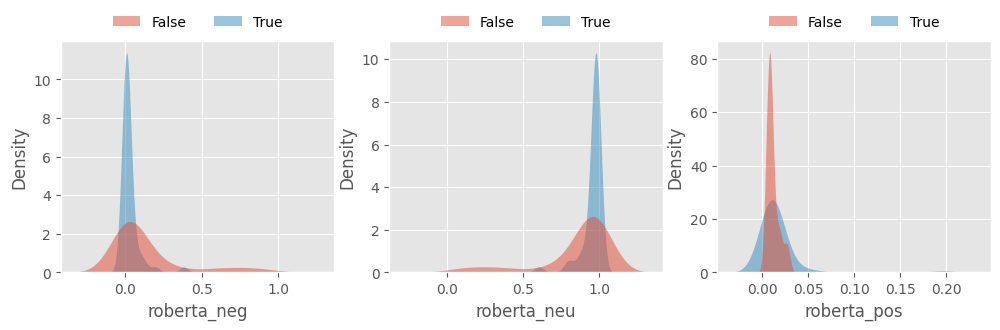

In [200]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

sns.kdeplot(ax=axs[0], data=results_df, x="roberta_neg", hue="Truthfulness",
   fill=True, common_norm=False, alpha=.5, linewidth=0)
sns.move_legend(axs[0], "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)

sns.kdeplot(ax=axs[1], data=results_df, x="roberta_neu", hue="Truthfulness",
   fill=True, common_norm=False, alpha=.5, linewidth=0)
sns.move_legend(axs[1], "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)

sns.kdeplot(ax=axs[2], data=results_df, x="roberta_pos", hue="Truthfulness",
   fill=True, common_norm=False, alpha=.5, linewidth=0)
sns.move_legend(axs[2], "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)